In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from Bio import SeqIO
from Bio import Seq
import sys

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import pairwise_distances
import time

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import tqdm

c = 20 # sys.argv[1] # chromsome
DE_NOVO_ASSEMBLE_DIR  = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/de_novo_assemble/'

DE_NOVO_ASSEMBLE_CHROM_DIR  = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/de_novo_assemble/chr%s/' % (str(c))

localized = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/unmapped/localized.tsv', comment='#')
localized.columns = ['# median_of_nonzeros', 'prevelance', 'chrom_pred', 'start_pred', 'end_pred']
localized.chrom_pred = [np.nan if np.isnan(i) else round(i) for i in localized.chrom_pred ]
print(100*np.mean(~np.isnan(localized.chrom_pred)),'% localized')
localized = localized[~np.isnan(localized.chrom_pred)]

93.73570065538608 % localized


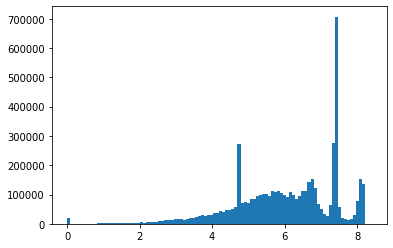

[(9.0, 1559093),
 (23.0, 869772),
 (22.0, 490749),
 (1.0, 375476),
 (21.0, 349185),
 (14.0, 305479),
 (15.0, 200419),
 (20.0, 184175),
 (4.0, 158599),
 (13.0, 119928),
 (5.0, 118789),
 (7.0, 114667),
 (10.0, 77431),
 (17.0, 69948),
 (2.0, 58094),
 (3.0, 55505),
 (6.0, 48999),
 (8.0, 39373),
 (11.0, 33505),
 (12.0, 33447),
 (18.0, 28270),
 (19.0, 27002),
 (16.0, 25029)]

In [2]:
plt.hist(np.log10(localized.end_pred-localized.start_pred), bins=100)
plt.show()
Counter(localized.chrom_pred).most_common()





# Comparing to hg38 Gaps

In [3]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_df = gaps_df[gaps_df.type=='N']

In [4]:
sizes_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38_chromsome_sizes.txt', header=None)
sizes_df = sizes_df.replace('X', 23).replace('Y', 24).replace('mtDNA', 25)
sizes_df[0] = [int(i) for i in sizes_df[0]]
sizes_df.sort_values(0, inplace=True)
sizes = [int(s.replace(',','')) for s in sizes_df[2]]
starts = [np.sum(sizes[:i]) for i in range(len(sizes)+1)]

def loci_linear_idx(chrom, loci):
    chrom=int(chrom)
    #if chrom==24: chrom=23
    return starts[chrom-1]+loci

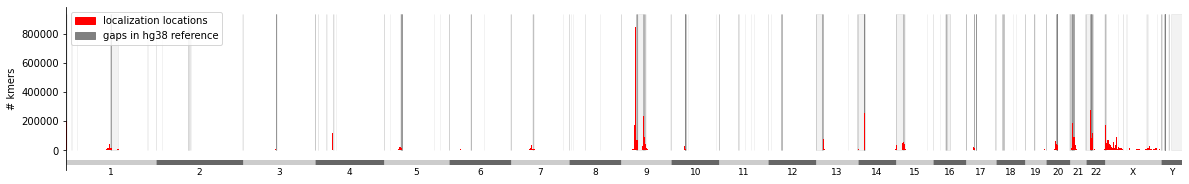

In [7]:
f, ax = plt.subplots(figsize=(20,3))
localized = localized[~np.isnan(localized.chrom_pred)]
linear_locs = [loci_linear_idx(chrom_pred, start_pred) for chrom_pred, start_pred in zip(localized.chrom_pred, localized.start_pred)]
nbins = plt.hist(linear_locs, bins=1000, color='r')
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df = gaps_df[gaps_df.type=='N']
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]
for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
    r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                  height=1.1*max(nbins[0]), width=stop-start, color='grey', alpha=.1)
    ax.add_patch(r)
    
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='grey')

p = plt.hist(linear_locs, bins=1000, color='r')
for i in range(24):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    if chrom=='24': chrom='Y'
    plt.text(x=np.mean(starts[i:(i+2)]), y=-max(p[0])/5, s=chrom, fontsize=9, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts[i], xmax=starts[i+1], y=-max(p[0])/10, color=color, linestyle='-', linewidth=5)
plt.legend([red_patch, grey_patch], ['localization locations', 'gaps in hg38 reference'])
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(starts[0], starts[-1])
ax.get_xaxis().set_ticks([])
plt.ylabel('# kmers')
plt.show()

In [120]:
c = 20
start_ends =  np.array(localized[localized.chrom_pred==c][['start_pred', 'end_pred']])

# Distance function
def myDist(l1,l2):
    return 1-(((l1[-2] >= l2[-2]) & (l1[-2] <= l2[-1])) | ((l2[-2] >= l1[-2]) & (l2[-2] <= l1[-1])))

t = time.time()
conn = pairwise_distances(X=localized[localized.chrom_pred==c].iloc[:1000], metric=myDist, n_jobs=-1)
print(time.time()-t)

10.942413091659546


In [160]:
from scipy.sparse import lil_matrix

In [249]:
# Compute Similarity Matrix
l = localized[localized.chrom_pred==c].sort_values(['start_pred', 'end_pred']).iloc[:1000][['start_pred', 'end_pred']]
m = lil_matrix(np.zeros((len(l), len(l))))
for i in range(len(l)):
    start = l.iloc[i].start_pred
    for j in range(i,len(l)):
        start2 = l.iloc[j].start_pred
        end2 = l.iloc[j].end_pred
        if (start2 <= start) & (start <=end2):
            m[i,j] = 1
            m[j,i] = 1
        else: break


In [250]:
sil = []
kmax = 6
n_clusters = [c for c in range(2, kmax+1)]
#AgglomerativeClustering(n_clusters=2, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)[source]

# Compute sillhouette score for each n_clusters.
for k in tqdm.tqdm(n_clusters):
    print(k)
    alg_clusters =AgglomerativeClustering(n_clusters=k, connectivity=m).fit(l)
    labels = alg_clusters.labels_
    sil.append(silhouette_score(l, labels, metric = 'euclidean'))
    print(sil)



  0%|          | 0/5 [00:00<?, ?it/s]

2


/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 1562 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


 20%|██        | 1/5 [02:43<10:55, 163.79s/it]

[0.5588554052289337]
3




 40%|████      | 2/5 [05:28<08:12, 164.01s/it]

[0.5588554052289337, 0.5989524981141393]
4




 60%|██████    | 3/5 [08:13<05:28, 164.47s/it]

[0.5588554052289337, 0.5989524981141393, 0.5360626813711055]
5




 80%|████████  | 4/5 [11:01<02:45, 165.34s/it]

[0.5588554052289337, 0.5989524981141393, 0.5360626813711055, 0.5684937471557998]
6




100%|██████████| 5/5 [13:48<00:00, 165.78s/it]

[0.5588554052289337, 0.5989524981141393, 0.5360626813711055, 0.5684937471557998, 0.5706742448591068]


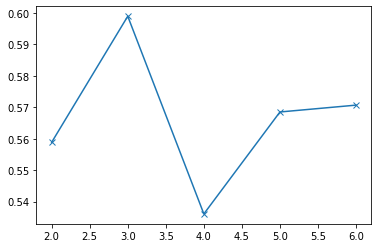

In [252]:
plt.plot(n_clusters[:len(sil)], sil, '-x')


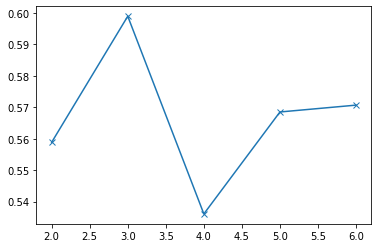

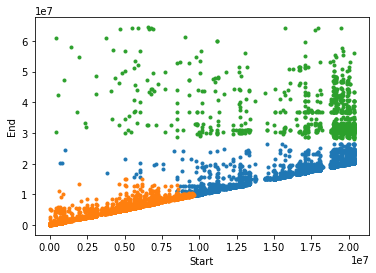

In [264]:
plt.plot(n_clusters[:len(sil)], sil, '-x')

# Retrain model with optimal clustering. 
#alg_clusters =AgglomerativeClustering(n_clusters= n_clusters[np.argmax(sil)], connectivity=m).fit(l)
alg_clusters = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(sil)], connectivity=m).fit(l)
labels = alg_clusters.labels_
plt.figure()
for ll in set(labels):
    plt.plot(l[labels==ll].start_pred, l[labels==ll].end_pred, '.')
plt.xlabel('Start')
plt.ylabel('End')
plt.show()


In [51]:
localized_chrom = localized[localized.chrom_pred==c][['start_pred', 'end_pred']]
localized_chrom = localized_chrom[~localized_chrom.duplicated()]
len(localized_chrom)

61552

In [30]:
sil = []
kmax = 12
n_clusters = [c for c in range(2, kmax+1)]
#AgglomerativeClustering(n_clusters=2, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)[source]

# Compute sillhouette score for each n_clusters.
for k in tqdm.tqdm(n_clusters):
    print(k)
    alg_clusters =AgglomerativeClustering(n_clusters=k, connectivity=conn).fit(start_ends[:len(conn)])
    labels = alg_clusters.labels_
    sil.append(silhouette_score(start_ends[:len(conn)], labels, metric = 'euclidean'))
    
# Optimal number of clusters.    
opt_clusters = n_clusters[np.argmax(sil)]
print('opt clusters', opt_clusters)
plt.figure()
plt.plot(n_clusters, sil)
plt.show()

# Retrain model with optimal clustering. 
alg_clusters =AgglomerativeClustering(n_clusters=opt_clusters, connectivity=conn).fit(start_ends[:len(conn)])
l = alg_clusters.labels_
for ll in set(l):
    plt.plot(X[:len(conn)][l==ll,0], X[:len(conn)][l==ll,1], '.')
plt.xlabel('Start')
plt.ylabel('End')
plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

2


  9%|▉         | 1/11 [09:13<1:32:10, 553.04s/it]

3


KeyboardInterrupt: 

[0.7686789436358942]

In [37]:
opt_clusters = n_clusters[np.argmax(sil)]
print('opt clusters', opt_clusters)
alg_clusters =AgglomerativeClustering(n_clusters=opt_clusters, connectivity=conn).fit(start_ends[:len(conn)])
l = alg_clusters.labels_
for ll in set(l):
    plt.plot(X[:len(conn)][l==ll,0], X[:len(conn)][l==ll,1], '.')
plt.xlabel('Start')
plt.ylabel('End')
plt.savefig(DE_NOVO_ASSEMBLE_CHROM_DIR + 'clusters.svg', 'svg')
plt.show()

opt clusters 2


KeyboardInterrupt: 

In [204]:
for l in [0,1,2]:
    print(min(X[:len(conn)][alg_clusters.labels_==l,0]), max(X[:len(conn)][alg_clusters.labels_==l,1]))

24737336.0 64302325.0
13343981.0 56780448.0
607446.0 13311119.0


In [ ]:
kmer_seqs = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/kmers_unmapped_prev_and_median_filt.txt', 
                          nrows=2000000, header=None)
kmer_seqs = kmer_seqs.loc[localized.index]
kmer_seqs = kmer_seqs[localized.chrom_pred==c].iloc[:len(conn)]
#kmer_seqs.loc[localized[localized['chrom_pred']==chrom].sort_values('start_pred').iloc[:100].index].values

In [143]:
for l in set(alg_clusters.labels_):
    print(l)
    sequences = [SeqIO.SeqRecord(seq = Seq.Seq(seq[0]), id=str(idx)) for idx, seq in kmer_seqs[alg_clusters.labels_==l].iterrows()]
    SeqIO.write(sequences,DE_NOVO_ASSEMBLE_CHROM_DIR + "cluster_%i.fasta" % (str(c), l), "fasta")
    print('Written to ', DE_NOVO_ASSEMBLE_CHROM_DIR + "cluster_%i.fasta" % (str(c), l))


0
Written to  /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/de_novo_assemble/chr20/cluster_0.fasta
1
Written to  /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/de_novo_assemble/chr20/cluster_1.fasta
2
Written to  /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/de_novo_assemble/chr20/cluster_2.fasta


In [145]:
%%bash
chrom=20
for file in /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/de_novo_assemble/chr${chrom}/*.fasta ; do

    echo "ASSEMBLING" ${file}
    assembled_dir=${file}/.fasta/_assembled
    # Remove previous directory to start clean.
    \rm ${assembled_dir} -r
    
    # Assemble.
    megahit -r $file -o ${assembled_di}
done

2021-08-31 14:09:17 - MEGAHIT v1.2.9
2021-08-31 14:09:17 - Using megahit_core with POPCNT and BMI2 support
2021-08-31 14:09:17 - Convert reads to binary library
2021-08-31 14:09:17 - b'INFO  sequence/io/sequence_lib.cpp  :   77 - Lib 0 (/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/de_novo_assemble/chr20/cluster_0.fasta): se, 345 reads, 100 max length'
2021-08-31 14:09:17 - b'INFO  utils/utils.h                 :  152 - Real: 0.0145\tuser: 0.0000\tsys: 0.0017\tmaxrss: 7264'
2021-08-31 14:09:17 - k-max reset to: 119 
2021-08-31 14:09:17 - Start assembly. Number of CPU threads 128 
2021-08-31 14:09:17 - k list: 21,29,39,59,79,99,119 
2021-08-31 14:09:17 - Memory used: 973408208486
2021-08-31 14:09:17 - Extract solid (k+1)-mers for k = 21 
2021-08-31 14:09:19 - Build graph for k = 21 
2021-08-31 14:09:20 - Assemble contigs from SdBG for k = 21
2021-08-31 14:09:20 - Local assembly for k = 21
2021-08-31 14:09:20 - Extract iterative edges from k = 21 to 29 
2021-08-31 14:09:

In [149]:
%%bash 
less /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/de_novo_assemble/chr20/cluster_1_assembled/final.contigs.fa

>k59_3 flag=1 multi=10.2291 len=967
ATATGTGGAATGTGATATATATAACATATAATATATGATATATGATATACAGTATATGATATATAACATACAATATATGATTCCTAATATATATGGTATACAATATATATTTTATGATATGTATTCTATATGTTTTATATTCTGTTATATATAACTATTTGAAATTATATATAACTGTATAATATTTTATGTAAATATGTAATATAATATATATAACTATATAATATATTATATATAACTATATATTATGTTATATATACTTTTATAACATAATTTACATAAAATATCATAATATAATATATATTATATTATTTCATATTACATAATATATATTACATATCACCCAATATAACTAACATACATAATATTATAATATAGATTATATTATGTTATATTAAATATCATATATATCATGTATCATATATTCTATAATATATATTACACATTATATAATATGTATGTTGTCTATTATGTGATATATATAACTATATATATAATTATATTATTATACATATAACTAGATAAACATGTAATTCTACATATTTTCATTTATAATATGTAGAATTATATAATCATATATAATTATTTATATTCTATAAAAAATTTTATCATTATATAAATTATAATATATAAAAATTATAATATGTACTACAAATATATATATTATATATCATATATGATATAGTACCTTTGTTATATATCATAATACATATAAATGTGTATTATGTTATCTATAATTATATAATTTCATATATAAGATGTATAATATGTATCATATATTATATATGTTATGTAATATATATAGTATATATAAGATGACACAGGATAAATATTATATACTATGACATATAAAATATATGAGGTTATATGTTACATATAAGGCATAGCACATAACATGTAATATATATCATATATAATTTTTTTTTAGACAGAATCTTGTCCTGTTGCACAGGGTGGGGTACAA

### Gap Statistic for Optimal Clusters

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
import joblib 
try:
    from sklearn.datasets.samples_generator import make_blobs
except ImportError:
    from sklearn.datasets import make_blobs
import multiprocessing
from sklearn.cluster import AgglomerativeClustering


In [11]:
def special_clustering_func(X, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    print(k)
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    m = AgglomerativeClustering(n_clusters=k,connectivity=conn[:len(X),:len(X)])
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return [np.mean(X[m.labels_==i,:]) for i in range(k)], m.labels_

optimalK = OptimalK(parallel_backend='joblib', clusterer=special_clustering_func, n_jobs=multiprocessing.cpu_count())


In [14]:
len(conn)

1000

In [15]:
t = time.time()
X = start_ends
print('Data shape: ', X.shape)

n_clusters = optimalK(X[:len(conn)], cluster_array=np.arange(1, 10))
print('Optimal clusters: ', n_clusters)
print(time.time()-t)

Data shape:  (184175, 2)
Optimal clusters:  9
353.8895266056061


In [16]:
# Now run clustering with optimal number of clusters.
c, l = special_clustering_func(X[:len(conn)], n_clusters)

9


/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 1000 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


In [ ]:
l = labels
for ll in set(l):
    plt.plot(X[:len(conn)][l==ll,0], X[:len(conn)][l==ll,1], '.')
plt.xlabel('Start')
plt.ylabel('End')
plt.show()

In [59]:
#sizes_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38_chromsome_sizes.txt', header=None)
#sizes = [int(s.replace(',','')) for s in sizes_df[2]]
#starts = [np.sum(sizes[:i]) for i in range(23)] + [3041559849]

f, ax = plt.subplots(figsize=(15,.5))
for i in range(24):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    if chrom=='24': chrom='Y'
    plt.text(x=np.mean(starts[i:(i+2)]), y=.4, s=chrom, fontsize=9, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts[i], xmax=starts[i+1], y=.6, color=color, linestyle='-', linewidth=7)
plt.xlim(0,starts[-1]+1e8)
ax.axis('off')
plt.ylim(.4,.6)
plt.tight_layout()
plt.show()

In [56]:
len(starts)

24

In [29]:
localized[localized['chrom_pred']==chrom].sort_values('start_pred').iloc[:100].index

Int64Index([31697, 19402, 55645, 71715, 12080, 72096, 32841,  1017, 42133,
            56628, 56647,   111, 56297, 16208, 20319, 77871, 94353, 66363,
            37899, 98272, 18312, 45328, 20326,  7394, 62779, 55493, 36137,
            92959, 94704, 29404, 60081, 86416, 65916, 45621,  6699, 30060,
             4968, 77714, 89551, 21955, 48927, 27093, 52945, 30937, 39619,
            93048, 83349, 76900, 66312, 14865, 46974, 80446, 29884,  4405,
            69861, 17728, 82129, 59738, 63199,   377, 27548, 98812, 73430,
            10895, 81430, 23859, 38574,  7503, 41596, 66612, 70101, 79693,
            94684, 47263, 43664, 64970,  3572, 83388, 26649, 76596, 70911,
            88077, 80738, 18132,  3214, 80230, 29841, 41331,  5009, 85623,
             5369, 68911, 31514, 28019, 30945, 47855, 92367, 62534,  3400,
            34596],
           dtype='int64')

In [30]:
chrom=9
kmer_seqs = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/kmers_unmapped_prev_and_median_filt.txt', 
                          nrows=100000, header=None)
kmer_seqs.loc[localized[localized['chrom_pred']==chrom].sort_values('start_pred').iloc[:100].index].values

array([['ACCCGAGTGTAATGGCATGGAATGGAACGGAATGGAATGGGATGGAATGGAATGGTACGGAATAGAATGGAATGGAATGAAATGGAATAGAAAGGAATGG'],
       ['CGAGTGGAATGGATTCGAATGGAATGGAATTGAATGGAGTGGACTGGAAAAAACTGGAATCGAATGGATTGGGAATGAATGGAATGGAATGGAATGCACA'],
       ['ACCCGAATGGAATGGAATGGATTGGAATGGAATGGAATGGAATCAAGCCCAGCGTAAAGGAATGGAATGGAATGGATTGGACTGGAATTTAATGGAATGG'],
       ['AATAGAAGGGAATGGTTTCGAGTGGAATGAAAAGGAATGGAATCAACCAGAGTGGAATGGAATGGAATCGAGTGGAATGGAATGCAATCGAATGGAATGG'],
       ['TGGAATTAACACGAATAGAATGGAATGGAATGGATCGGAATGGAATGGAATCAACGTGAGTGCTGGGGATTGGAATGGAATGGAATGCAATGGAATGGAA'],
       ['ATTCCGGAAGATTCCATTCCATTGCATTCCATTCCATTCCATTCCCCTGCACTCGCGTTGATTCCATTCCATTCCATTCCATTCCATCCCATTCCATCCC'],
       ['AATGGAATAGAATGAAATGGAATTGTGTGGAATGGAATGGAATTGAATGGAGTGTAAAAGAATTGAATAGAATCAACCCGAATAGAATGGAATGTAATGG'],
       ['CCATTCCATTACATTCGGATTGATTCTATTCAACTCCCTTACATTCCATTACATTCCATTCCATTCGGGTTGTTCCATTCCATTCCATTCCATTCCCCTC'],
       ['ATACCATTCCATTCCATTGTATGCCATTCCATTCCATTCCACTCGGGTTCATTCCATTCCATTCCACTCCATTCCTTTACATTCCAT

In [25]:
kmer_seqs

,0
0,CATCCCATTCCGTTCCGTTGCATTCCATTCCATTACATTTGGATTG...
1,ATAGAATATATGATACATGATATATATGATATTTAATATAACATAA...
2,ACTATATGTCATATTGTATAAATATAAAACTTATATATTATCAATT...
3,GCATTCTTTATTTTACATGTAATAAATTATACATTATAGGGAACAT...
4,AATGGAATGGTATGGAAAGGAAAGGAATGTAATTGAATAGAATGGA...
...,...
9995,TATAAAAGTATATATAACATAATATATAGTTATATATAATATATTA...
9996,GAGTGGAATGGAGTGTAGTGGAATGGAGTGGAGTGGAATGGAGCGG...
9997,ATTTTACATGTAATAAATTATACATTATAGGTAACATAGTATATAG...
9998,ATTCGGGTAGTTTCCATTGCATTCCATTCCATTCCTCTCTGTTCCA...


In [65]:
kmer_seqs

,0
0,CATCCCATTCCGTTCCGTTGCATTCCATTCCATTACATTTGGATTG...
1,ATAGAATATATGATACATGATATATATGATATTTAATATAACATAA...
2,ACTATATGTCATATTGTATAAATATAAAACTTATATATTATCAATT...
3,GCATTCTTTATTTTACATGTAATAAATTATACATTATAGGGAACAT...
4,AATGGAATGGTATGGAAAGGAAAGGAATGTAATTGAATAGAATGGA...
...,...
9995,TATAAAAGTATATATAACATAATATATAGTTATATATAATATATTA...
9996,GAGTGGAATGGAGTGTAGTGGAATGGAGTGGAGTGGAATGGAGCGG...
9997,ATTTTACATGTAATAAATTATACATTATAGGTAACATAGTATATAG...
9998,ATTCGGGTAGTTTCCATTGCATTCCATTCCATTCCTCTCTGTTCCA...


In [1]:
chrom=14
f, ax = plt.subplots(figsize=(20,3))
nbins = plt.hist(localized[localized['chrom_pred']==chrom][3], bins=1000, color='blue')
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_df = gaps_df[gaps_df.type=='N']
gaps_df = gaps_df[gaps_df.chrom==('chr'+str(chrom))]
#plt.hist(gaps_df.start, bins=1000)
for start, stop in zip(gaps_df.start, gaps_df.stop):
    r = Rectangle(xy=(start, 0), height=max(2*nbins[1]), width=stop-start, color='grey', alpha=.3)
    ax.add_patch(r)
nbins = plt.hist(localized[localized['chrom_pred']==chrom][3], bins=1000, color='blue')

#plt.xlim(0,stop)
plt.show()

NameError: name 'plt' is not defined

In [12]:
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']

In [41]:
bam_mappings = bam_mappings.drop('09C86428')

,status,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,derived_affected_status,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
sample_id,,,,,,,,,,,,,,,,,,,,,
02C10540,Passed_QC_analysis_ready,AU1005201,AU1005,HI2393,02C10540,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10541,Passed_QC_analysis_ready,AU1005202,AU1005,HI2394,02C10541,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10542,Passed_QC_analysis_ready,AU1005302,AU1005,HI2395,02C10542,sibling,AU1005201,AU1005202,2.0,broad-spectrum,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10543,Passed_QC_analysis_ready,AU1005301,AU1005,HI2396,02C10543,sibling,AU1005201,AU1005202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10702,Passed_QC_analysis_ready,AU1004202,AU1004,HI2397,02C10702,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MH0143008,Passed_QC_analysis_ready,AU3859201,AU3859,HI11780,MH0143008,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MH0143009,Passed_QC_analysis_ready,AU3859202,AU3859,HI11781,MH0143009,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MH0143013,Passed_QC_analysis_ready,AU3859303,AU3859,HI11784,MH0143013,sibling,AU3859201,AU3859202,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
